### Sleep state detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuropy import plotting
import subjects

sessions = subjects.nsd.ratVday3

channel for sleep detection: (80, 82)
spectral properties calculated
starting emg calculation
emg calculation done
/data/Clustering/sessions/RatV/RatVDay3NSD/RatV_Day3NSD_2021-10-07_08-10-12.brainstates saved


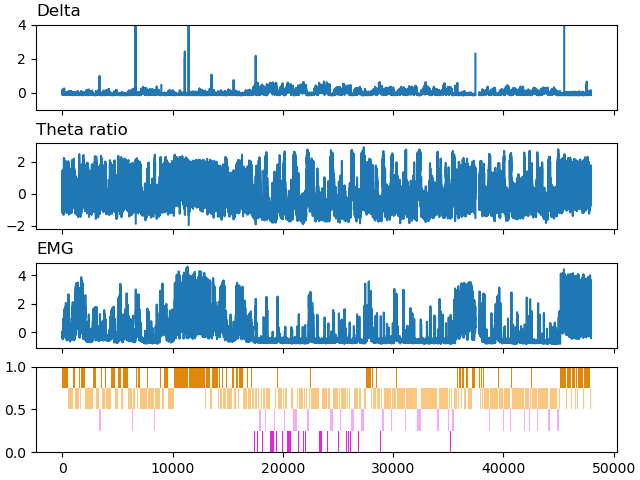

In [2]:
from neuropy.analyses import detect_brainstates_epochs

for sub, sess in enumerate(sessions):
    signal = sess.eegfile.get_signal()
    brainstates = detect_brainstates_epochs(
        signal,
        probe=sess.probegroup,
        theta_channel=80,
        delta_channel=82,
        sigma=1,
        ignore_epochs=sess.artifact,
    )
    brainstates.save(sess.filePrefix.with_suffix('.brainstates'))


In [3]:
np.array(['']*10,dtype='U4')

array(['', '', '', '', '', '', '', '', '', ''], dtype='<U4')

### View brainstates detection in ephyviewer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuropy import plotting
from brainstates_editor import editor
from ephyviewer import mkQApp
import subjects

app = mkQApp()
sess = subjects.nsd.ratVday1[0]
sigs = sess.eegfile.get_signal(20)

win = editor(
    sess.brainstates,
    sigs,
    filename=sess.filePrefix.with_suffix(".test"),
    paradigm=sess.paradigm,
)
win.show()
app.exec_()


### Sleep fraction during 5 hours following MAZE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuropy import plotting
import subjects

sessions = subjects.sd.brainstates_sess + subjects.nsd.brainstates_sess

In [ ]:
sleep_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post= sess.paradigm["post"].flatten()
    period = [post[0],post[0] + 5 * 3600]
    prop = sess.brainstates.get_proportion_by_label(period[0], period[1])
    if "nan" in prop.keys():
        del prop["nan"]

    sleep_df = sleep_df.append(
        pd.DataFrame(
            {
                "prop": list(prop.values()),
                "state": list(prop.keys()),
                "grp":sess.tag,
            }
        ),
        ignore_index=True,
    )

subjects.GroupData().save(sleep_df,'brainstates_proportion')

### Combining brainstates into dataframe for plotting in sd_figure3
- only POST epoch and in Zt time

In [ ]:
import numpy as np
from subjects import sd,nsd,GroupData
import pandas as pd

sessions = (
    sd.ratKday1
    + sd.ratNday1
    + sd.ratSday3
    + sd.ratUday4
    + sd.ratVday2
    + sd.ratRday2

    + nsd.ratKday2
    + nsd.ratNday2
    + nsd.ratSday2
    + nsd.ratUday2
    + nsd.ratVday1
)

In [ ]:
brainstates_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    states = sess.brainstates.time_slice(post[0], post[1])
    starts = (states.starts - post[0]) / 3600
    stops = (states.stops - post[0]) / 3600
    df = pd.DataFrame(
        dict(
            start=starts,
            stop=stops,
            label=states.labels,
            sub=sub,
            name=sess.animal.name,
            grp=sess.tag,
        )
    )
    brainstates_all.append(df)

brainstates_all = pd.concat(brainstates_all, ignore_index=True)

GroupData().save(brainstates_all, "ev_brainstates")


### Implement IRASA

In [ ]:
import numpy as np
import scipy.signal as sg
import subjects
import fractions
from scipy import stats
from fooof import FOOOF,FOOOFGroup

sess = subjects.nsd.ratUday2[0]
maze = sess.paradigm["maze"].flatten()
post = sess.paradigm["post"].flatten()
# period = [maze[0], maze[1]]
period = [post[0]+3600,post[0]+2*3600]
# period = [0,sess.eegfile.duration]
data = sess.eegfile.get_signal(150, *period).traces[0]
# data = sess.eegfile.get_signal(150).traces[0]

welch_kw = dict(nperseg=4*1250,noverlap=625)
freqs, psd = sg.welch(data, fs=1250, **welch_kw)
# f, t, spect = sg.spectrogram(data, fs=1250, nperseg=2*1250, noverlap=625)

# Start the IRASA procedure
hset = np.arange(1.1, 2.9, 0.05).round(4)
hset = np.delete(hset, 18)
psds = np.zeros((len(hset), *psd.shape))

fm = FOOOF()
freq_range = [4,90]

# fm.report(freqs,psd,freq_range)
fm.report(freqs,psd,freq_range)
# fm.plot()
# fm.power_spectrum

# for i, h in enumerate(hset):
#     # Get the upsampling/downsampling (h, 1/h) factors as integer
#     rat = fractions.Fraction(str(h))
#     up, down = rat.numerator, rat.denominator
#     # Much faster than FFT-based resampling
#     spect_up = sg.resample_poly(spect, up, down, axis=0)
#     spect_down = sg.resample_poly(spect, down, up, axis=0)
#     psds[i, :] =np.dstack([spect_up,spect_down]).mean(axis=-1)

# for i, h in enumerate(hset):
#     # Get the upsampling/downsampling (h, 1/h) factors as integer
#     rat = fractions.Fraction(str(h))
#     up, down = rat.numerator, rat.denominator
#     # Much faster than FFT-based resampling
#     data_up = sg.resample_poly(data, up, down, axis=-1)
#     data_down = sg.resample_poly(data, down, up, axis=-1)
#     # Calculate the PSD using same params as original
#     freqs_up, psd_up = sg.welch(data_up, h * 1250, **welch_kw)
#     freqs_dw, psd_dw = sg.welch(data_down, 1250 / h, **welch_kw)
#     # Geometric mean of h and 1/h
#     # psds[i, :] = np.vstack((psd_up, psd_dw)).mean(axis=0)
#     psds[i, :] = np.sqrt(psd_up * psd_dw)



# Now we take the median PSD of all the resampling factors, which gives
# a good estimate of the aperiodic component of the PSD.
# psd_aperiodic = np.median(psds, axis=0)
# print(psd_aperiodic.shape,psd_aperiodic[:2])

# # We can now calculate the oscillations (= periodic) component.
# psd_osc = psd - psd_aperiodic

# # Let's crop to the frequencies defined in band
# mask_freqs = np.ma.masked_outside(freqs, *band).mask
# freqs = freqs[~mask_freqs]
# psd_aperiodic = np.compress(~mask_freqs, psd_aperiodic, axis=-1)
# psd_osc = np.compress(~mask_freqs, psd_osc, axis=-1)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
indices = (freqs>=4)&(freqs<=90)
p = psd[indices]
plt.plot(freqs[indices],np.log10(p))
plt.plot(freqs[(freqs>=4)&(freqs<=90)],fm._ap_fit)
# plt.yscale('log')

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
f,t,spect = sg.spectrogram(data,fs=1250,**welch_kw)
ind = (f>=4)&(f<=90)
spect = np.log10(spect[ind,:])
# spect_osc = spect- fm._ap_fit[:,np.newaxis]
# spect_osc[spect_osc<0]=0

# req_ind = (f>1)&(f<30)
# # delta_ind = (f>0.5)&(f<4)
# theta_ind = (f>5)&(f<10)
# # delta_sxx = spect_osc[delta_ind,:].mean(axis=0)
# theta_sxx = spect_osc[theta_ind,:].mean(axis=0)

_,axs = plt.subplots(5,1,sharex=True)

axs[0].imshow(spect,origin='lower',aspect='auto',cmap='jet',extent=[t[0],t[-1],4,90])
# axs[1].imshow(spect[req_ind,:],origin='lower',aspect='auto',vmax=25000,cmap='jet',extent=[t[0],t[-1],1,30])

# axs[2].plot(t,theta_sxx)
# axs[3].plot(t,delta_sxx)
# axs[4].plot(t,theta_sxx/delta_sxx)



In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.plot(freqs,psd_aperiodic)
plt.plot(freqs,psd)
plt.plot(freqs,psd-psd_aperiodic)
plt.yscale('log')
plt.xscale('log')

### Some measure of micro-arousal in sleep vs recovery sleep using emg only

In [7]:
import numpy as np
from neuropy.analyses.brainstates import detect_brainstates_epochs
from neuropy.core import Epoch
from scipy.ndimage import gaussian_filter1d
from neuropy.analyses.brainstates import correlation_emg
from scipy import stats
from neuropy.analyses.brainstates import hmmfit1d
import matplotlib.pyplot as plt
from neuropy.plotting import plot_hypnogram
import subjects

smooth = lambda arr:gaussian_filter1d(arr,sigma=2/1)

sessions = subjects.nsd.ripple_sess[2:3] + subjects.sd.ripple_sess[2:3]

In [10]:
sessions

[ProcessData(RatN_Day2_2019-10-11_03-58-54.xml),
 ProcessData(RatN_Day1_2019-10-09_03-52-32.xml)]

In [8]:
emg_all=[]
for sub,sess in enumerate(sessions):
    pre = sess.paradigm['pre'].flatten()
    maze = sess.paradigm['maze'].flatten()
    post = sess.paradigm['post'].flatten()
    if sess.tag=='NSD':
        period = [post[0],post[0]+4*3600]
    if sess.tag=='SD':
        period = [post[0]+5*3600,post[0]+9*3600]

    all_channels = np.concatenate(sess.probegroup.get_connected_channels()).astype('int')
    signal = sess.eegfile.get_signal(t_start=period[0],t_stop=period[1])
    emg = correlation_emg(signal,sess.probegroup,10,9)
    emg_all.append(smooth(emg))


starting emg calculation
emg calculation done
starting emg calculation
emg calculation done


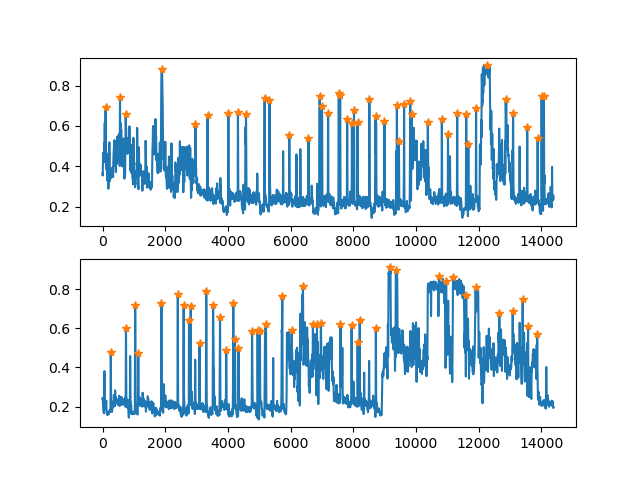

In [15]:
from scipy.signal import find_peaks
_,axs = plt.subplots(2,1)

for i,e in enumerate(emg_all):
    peaks = find_peaks(e,prominence=0.3)[0]
    axs[i].plot(e)
    axs[i].plot(peaks,e[peaks],'*')